In [1]:
import pandas as pd

In [2]:
%store -r freak_df
%store -r Lore_df
%store -r Invisible_df
%store -r tal_df
%store -r OnBeing_df
%store -r radiolab_df
%store -r uu_df
%store -r StoryCorps_df
%store -r YWA_df
%store -r myDNA_df
%store -r Nightvale_df
# read in maxfun data then store

In [3]:
# create a multindexed dataframe
data = pd.concat([freak_df, Lore_df, Invisible_df, tal_df, OnBeing_df, radiolab_df, 
                  uu_df, StoryCorps_df, YWA_df, myDNA_df, Nightvale_df],
                 keys=['Freakonomics','Lore','99% Invisible','This American Life','On Being',
                       'Radiolab','Unlocking Us','Story Corps','You\'re Wrong About','Move Your DNA',
                       'Welcome to Nightvale'])

In [4]:
data

Episode  Year  \
Freakonomics         14     001  2010   
                     15     002  2010   
                     18     003  2010   
                     17     004  2010   
                     26     005  2010   
...                         ...   ...   
Welcome to Nightvale 72     180  2020   
                     0      181  2021   
                     1      182  2021   
                     2      183  2021   
                     3      184  2021   

                                                                     Title  \
Freakonomics         14                              The Dangers of Safety   
                     15            Is America’s Obesity Epidemic For Real?   
                     18  What Would the World Look Like if Economists W...   
                     17                                          Faking It   
                     26  How Is a Bad Radio Station Like the Public Sch...   
...                                                                    ...   
Welcome to Nightvale 72                                             u view   
                     0                                                  cs   
                     1                                  it sticks with you   
                     2                                        the nephilim   
                     3                                             the fog   

                                                                      Text  
Freakonomics         14  Peltzman Effect  fatal shark attacks  Dr. Robe...  
                     15  female-male weight gap  plumbing and obesity  ...  
                     18  professor of economics  blogs  a podcast of hi...  
                     17  elsewhere  RSS feed  readthe transcript  Barac...  
                     26  School of One  Joel Rose  Chris Rush  worked w...  
...                                                                    ...  
Welcome to Nightvale 72  “Yeah, there’s a VHS copy of   that we lent ou...  
                     0   I myself have mixed feelings on the subject. W...  
                     1   Hi listeners. It’s been a dull winter, and I h...  
                     2   We gather at the edge of town, nudge each othe...  
                     3   Meteorologists are closely watching a dense fo...  

[2606 rows x 4 columns]

I don't yet have the data from maximum fun (working on web-scraping embedded pdfs), I can start analysis here.  I'm going to start with basic text stats like the ones from homework 2 - token count, word length, sentence length, etc.

In [5]:
dir(data)

['Episode',
 'T',
 'Text',
 'Title',
 'Year',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',

ZeroDivisionError: integer division or modulo by zero

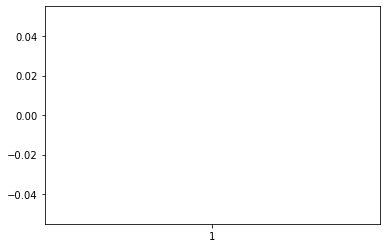